In [43]:
import json

import nibabel as nib
import sys
from matplotlib import pyplot as plt
sys.path.append('bin')
import bin.analysis as analysis
import bin.representation_geometry as geo
import numpy
import numpy as np
import torch
from torch import nn
import pandas as pd
import networkx as nx
import graspologic as gr
from bin.graphIO import GraphIO

In [44]:
# grab the shape color beta matrix
beta = '/Users/loggiasr/Projects/ColorContrastSpatialFrequency_local/Subjects/CCSF/analysis/representational/castor_ccsf_combined_betas.nii.gz'
beta_nii = nib.load(beta)
affine = beta_nii.affine
header = beta_nii.header
beta = np.array(beta_nii.get_fdata())[:, :, :, :]


In [45]:
brain_mask_nii = nib.load('/Users/loggiasr/Projects/ColorContrastSpatialFrequency_local/Subjects/CCSF/mri/rbrain.nii')
brain_mask = torch.from_numpy(np.array(brain_mask_nii.get_fdata().astype(bool)))

In [46]:
atlas_nii = nib.load("/Users/loggiasr/Projects/ColorContrastSpatialFrequency_local/Subjects/CCSF/analysis/ds_castor_visual_area_rois.nii.gz")
atlas = torch.from_numpy(atlas_nii.get_fdata()).int()
lookup = pd.read_csv("/Users/loggiasr/Projects/fmri/monkey_fmri/MTurk1_frozen_20220527/D99_v2.0_dist/d99_color_map_mk2.txt", header=1, index_col=0, delimiter='\t')

In [47]:
atlas_idxs = torch.unique(atlas).tolist()[1:]

In [48]:
import math

flat_beta = torch.from_numpy(beta)[atlas > 0]
beta_mag = torch.sum(flat_beta, dim=1)
cutoff = math.ceil(1* len(beta_mag))
_, sort_idxs = torch.sort(beta_mag, descending=True)
to_use = sort_idxs[:cutoff]
flat_beta = flat_beta[to_use]


In [49]:
proj, vecs, vals = geo.pca(flat_beta, noisy=True, n_components=2)
flat_atlas = atlas[atlas > 0]
flat_atlas = flat_atlas[to_use]

In [50]:
def rgb_to_hex(r, g, b):
  return ('{:X}{:X}{:X}').format(int(r), int(g), int(b))

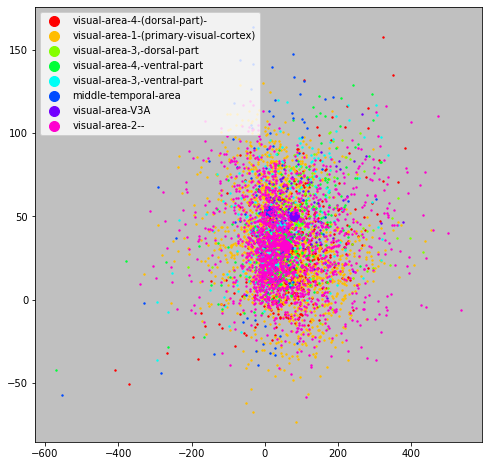

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches((8, 8))
idxs = torch.randperm(proj.shape[0])[:5000]
proj_sample = proj[idxs, :]
cmap = plt.get_cmap('hsv')
num_rois = len(atlas_idxs)
for i, key in enumerate(atlas_idxs[:]):
    c = cmap(float(i / num_rois))
    label = lookup.loc[key]['Label Name:']
    roi_proj = proj_sample[flat_atlas[idxs]==key, :]
    mean = torch.mean(roi_proj, dim=0)
    ax.scatter(roi_proj[:, 0], roi_proj[:, 1], s=2, color=c, alpha=1)
    ax.scatter(mean[0], mean[1], s=100, color=c, marker='o', label=label)
# ax.set_ylim(-10, 10)
# ax.set_xlim(25, 125)
ax.set_facecolor('silver')
plt.legend()
plt.show()


In [52]:
print(vecs[:, 1:3].T.tolist())
print(len(vecs[1]))

[[-0.38728418512683477, -1.2172845410095747, -1.0279331117819446, -0.47066090116246156, -1.3583754782887707, -0.5519658939463669, -2.346822353040834, -2.8504906757895934, -0.8628978465601603, -2.6724509868407456, -2.7512737906005693, -3.6333296181257464, -0.2426441218613691, -0.5322969946853269, -1.4424084820131458, -2.3795378585951363, -0.16236920803350813, -1.685191763573811, -0.42152326928486084, -0.8827337487638672, -1.360179174851684, -2.5793593791181655, -1.1764523546825674, -1.6407811013405063, -0.955548282609565, -1.348802313375999, -2.913337089158097, -4.581040165248511, -0.020079452490759337, -1.820373692525307, -2.7373299836989093, -2.7376224807411136, 0.4030289106344857, -0.033158145118464426, -1.1462397350710343, -1.0057162590154576, 6.604159345960237, 11.479180283594964, 3.412182632516166, 4.821517703170135, 3.2780864765915863, 0.2902960568493208, 4.155657096013986, 10.072656223474223, 2.660550993322692], [-2.400565881646468, -1.1325006156205764, -0.5516567936001197, -1.4

BIC for 1 components is 930531.9601127363
BIC for 2 components is 920034.8787978152
BIC for 3 components is 915291.7020544112
BIC for 4 components is 914781.2145106705
BIC for 5 components is 913373.6894683612
BIC for 6 components is 913079.3757192886
BIC for 7 components is 912778.0437625523


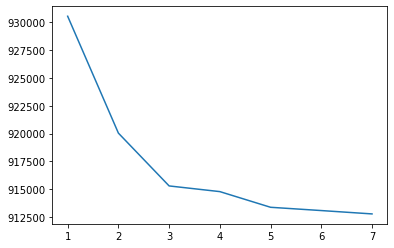

In [53]:
from sklearn.mixture import GaussianMixture
component_min = 1
component_max = 8
bics = []
gmms = []
gmm_beta = flat_beta @ vecs[:, 1:12].numpy()
for n_comp in range(component_min, component_max):
    gmm = GaussianMixture(n_components=n_comp)
    gmm.fit(gmm_beta)
    bic = gmm.bic(gmm_beta)
    print("BIC for", n_comp, "components is", bic)
    bics.append(bic)
    gmms.append(gmm)
plt.plot(range(component_min, component_max), bics)

In [54]:
best_gmm = gmms[2]
print(best_gmm.means_)

[[ 2.72263696e+01  3.79435818e+01 -2.78300920e-01  6.59916166e-01
  -4.78189254e+00  3.10796142e-01 -1.69187979e+00  2.76026661e-01
   2.23065456e+00 -1.55189200e-01 -3.59962694e-01]
 [ 9.79213147e+01  2.72256651e+01 -5.07945978e+00  2.55711987e+00
  -1.91421116e+00  4.15301753e-01  4.80880170e-01  8.61393916e-01
   1.05911612e+00  5.65478200e-02  8.74461523e-03]
 [ 1.85544390e+01  4.95738738e+01 -4.51642961e+00  4.19595325e+00
   1.99495122e+00 -1.07886303e+00 -7.33551948e-01  1.33464849e+00
   2.74273352e+00 -1.02394024e+00  6.27320334e-02]]


In [55]:
labels = best_gmm.predict(gmm_beta)
unique_labels = np.unique(labels)
for roi in atlas_idxs:
    roi_idxs = (flat_atlas == roi).numpy()
    roi_size = np.count_nonzero(roi_idxs)
    for label in unique_labels:
        label_idxs = (labels==label)
        truth = numpy.logical_and(roi_idxs, label_idxs)
        overlap = np.count_nonzero(truth)
        percent_label = overlap / roi_size
        print(100 * float(percent_label), "% of roi", lookup.loc[roi]['Label Name:'], "assigned to label ", int(label))

48.32 % of roi visual-area-4-(dorsal-part)- assigned to label  0
38.0 % of roi visual-area-4-(dorsal-part)- assigned to label  1
13.68 % of roi visual-area-4-(dorsal-part)- assigned to label  2
56.09195402298851 % of roi visual-area-1-(primary-visual-cortex) assigned to label  0
34.074074074074076 % of roi visual-area-1-(primary-visual-cortex) assigned to label  1
9.83397190293742 % of roi visual-area-1-(primary-visual-cortex) assigned to label  2
27.09030100334448 % of roi visual-area-3,-dorsal-part assigned to label  0
60.86956521739131 % of roi visual-area-3,-dorsal-part assigned to label  1
12.040133779264215 % of roi visual-area-3,-dorsal-part assigned to label  2
45.46875 % of roi visual-area-4,-ventral-part assigned to label  0
38.59375 % of roi visual-area-4,-ventral-part assigned to label  1
15.937499999999998 % of roi visual-area-4,-ventral-part assigned to label  2
41.19718309859155 % of roi visual-area-3,-ventral-part assigned to label  0
46.12676056338028 % of roi visual-a

In [56]:
print(vecs[:, :2].T.tolist())
print(len(vecs[1]))

[[36.173536877547406, 42.60075583430666, 54.56452557034705, 93.4522614240291, 44.13379678870632, 64.17397627501161, 80.01744212059846, 129.50199343821293, 32.30829937163895, 48.04009165977861, 60.29291115009995, 132.98577993222122, 39.26455490060971, 28.603878277934054, 65.22849668379155, 120.6950127719088, 52.745558757444094, 54.39885307475686, 59.728245945996626, 109.90738288277952, 45.4730364271815, 71.63653373912206, 100.34924282578619, 121.23816483422814, 44.1271072005406, 59.52523663184827, 62.842264854863856, 85.37610016874629, 36.268659450826235, 40.978212669410276, 59.1560684120923, 105.44523259555228, 64.64939553940894, 89.32739641742718, 107.39434761590532, 124.17741447519121, 110.86010203704183, 130.06797790229692, 36.174875434193574, 86.45115253176385, 34.06338420221097, 6.016441109018137, 76.83678356018181, 98.02007166820255, 29.166503197737125], [-0.38728418512683477, -1.2172845410095747, -1.0279331117819446, -0.47066090116246156, -1.3583754782887707, -0.5519658939463669

In [57]:
corr_adj, roi_idx, rdms, pvals = geo.pairwise_rsa(flat_beta, atlas=flat_atlas, ignore_atlas_base=False, metric='cosine')

Computed Correlation  tensor(318, dtype=torch.int32) ,  tensor(332, dtype=torch.int32)
Computed Correlation  tensor(318, dtype=torch.int32) ,  tensor(358, dtype=torch.int32)
Computed Correlation  tensor(318, dtype=torch.int32) ,  tensor(373, dtype=torch.int32)
Computed Correlation  tensor(318, dtype=torch.int32) ,  tensor(391, dtype=torch.int32)
Computed Correlation  tensor(318, dtype=torch.int32) ,  tensor(393, dtype=torch.int32)
Computed Correlation  tensor(318, dtype=torch.int32) ,  tensor(421, dtype=torch.int32)
Computed Correlation  tensor(318, dtype=torch.int32) ,  tensor(429, dtype=torch.int32)
Computed Correlation  tensor(332, dtype=torch.int32) ,  tensor(358, dtype=torch.int32)
Computed Correlation  tensor(332, dtype=torch.int32) ,  tensor(373, dtype=torch.int32)
Computed Correlation  tensor(332, dtype=torch.int32) ,  tensor(391, dtype=torch.int32)
Computed Correlation  tensor(332, dtype=torch.int32) ,  tensor(393, dtype=torch.int32)
Computed Correlation  tensor(332, dtype=tor

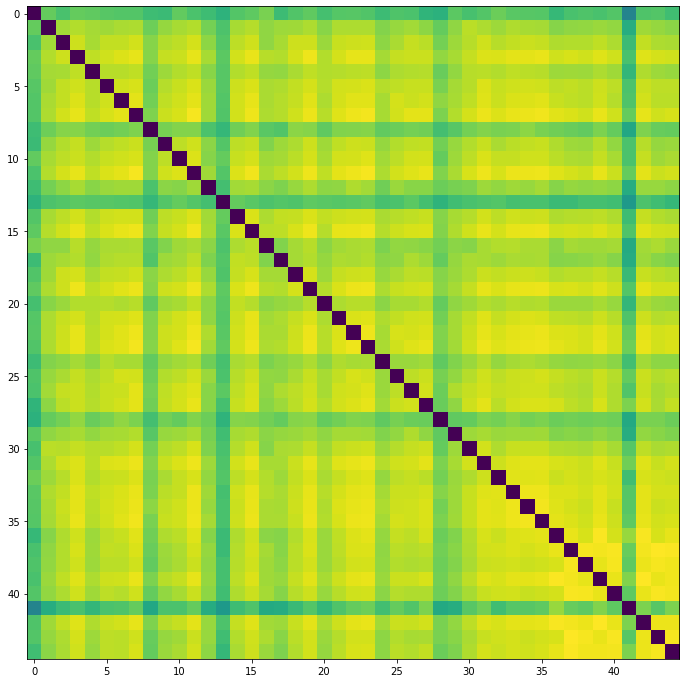

In [65]:
rdm = rdms[7].numpy()
size = flat_beta.shape[1]
rdm_mat = np.zeros((size, size))
rdm_mat[np.triu_indices(rdm_mat.shape[0], k = 1)] = rdm
rdm_mat = rdm_mat + rdm_mat.T
fig, ax = plt.subplots()
ax.imshow(rdm_mat)
fig.set_size_inches(12, 12)
plt.show()